<a href="https://colab.research.google.com/github/Yamini-14sri/FMML-22JN1A4323/blob/main/FMML_Module_9_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 9: Convolutional Neural Networks
## **Lab 4**
### Module coordinator: Kushagra Agarwal

<img src="https://miro.medium.com/max/1200/1*QoqNAg2t6lF8Q6WWA6AbOg.png" width=650px/>

## Using learnt representations
In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.


We'll train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.




In [1]:
# Import packages
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import time
import os

In [2]:
# Device configuration (whether to run on GPU or CPU)
device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Download and extract dataset
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip -q hymenoptera_data.zip

--2024-05-13 16:30:22--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.225.4.25, 13.225.4.109, 13.225.4.72, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.225.4.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  73.4MB/s    in 0.6s    

2024-05-13 16:30:22 (73.4 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_dir = './hymenoptera_data'
train_dataset = ImageFolder(os.path.join(data_dir, 'train'), train_transform)
val_dataset = ImageFolder(os.path.join(data_dir, 'val'), val_transform)
train_dataloader = DataLoader(train_dataset, batch_size=4,shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=4,shuffle=True, num_workers=2)
class_names = train_dataset.classes


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


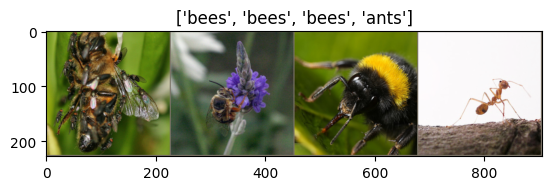

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, train_dataloader, criterion, optimizer, num_epochs=25):

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)

              # backward + optimize only if in training phase
              loss.backward()
              optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        epoch_acc = running_corrects.double() / len(train_dataloader.dataset)

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

In [7]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
from torchvision import models

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

loss_func = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 103MB/s]


In [9]:
num_epochs = 5
train_model(model_ft, train_dataloader, loss_func, optimizer, num_epochs)

Epoch 0/4
----------
Loss: 0.6166 Acc: 0.6639

Epoch 1/4
----------
Loss: 0.4415 Acc: 0.8033

Epoch 2/4
----------
Loss: 0.4180 Acc: 0.8320

Epoch 3/4
----------
Loss: 0.5573 Acc: 0.7869

Epoch 4/4
----------
Loss: 0.5972 Acc: 0.7664



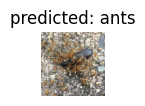

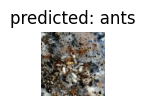

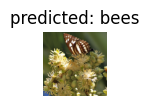

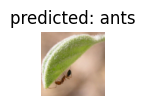

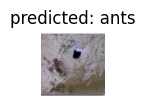

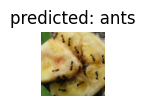

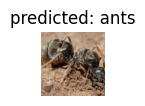

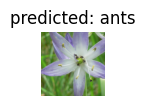

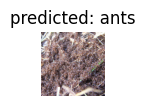

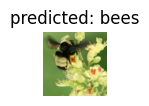

In [10]:
visualize_model(model_ft)

## Example of How Pretrained models are used for Target Tasks

<img src="https://www.researchgate.net/publication/340225334/figure/fig2/AS:960014822944773@1605896778155/Mechanism-of-transfer-learning-using-pre-trained-models.png" width=950px/>

## Questions:
1) What is the significance of using data augmentations like resize, crop etc on training data?

2) What performance do you get if you don't use pretrained resnet model (Hint: Change pretrained=False and train the model)

3) If the resnet model was pre-trained on dataset significantly different than the ants vs bees data, would you still get good performance by using this pretrained model?


ANSWER-1


Data augmentation techniques, such as resizing, cropping, rotation, flipping, and color jittering, play a significant role in improving the generalization and robustness of machine learning models, particularly in tasks like image classification. Here's why data augmentation is important:

Increased Variability: By applying various transformations to the training data, data augmentation increases the variability of the dataset. This helps the model learn to generalize better to unseen data by exposing it to a wider range of variations in the input space. For example, a model trained on images of cats that are all centered and facing forward might not perform well on images where cats are in different poses or orientations. Data augmentation helps address this issue by presenting the model with diverse examples.

Reduced Overfitting: Data augmentation acts as a form of regularization by introducing noise and variations into the training data. This helps prevent the model from memorizing specific features of the training examples and encourages it to learn more robust and invariant representations. As a result, data augmentation can mitigate overfitting, especially when the training dataset is limited.

Improved Robustness: Models trained with augmented data tend to be more robust to various transformations and distortions in the input data. For example, a model trained on images that are resized, cropped, and flipped is likely to perform better when presented with test images that have undergone similar transformations. This is particularly important in real-world scenarios where input data may exhibit different conditions and variations.

Better Generalization: Data augmentation helps models learn features that are invariant to certain transformations. For instance, a model trained on images of handwritten digits that are translated, rotated, and scaled is more likely to learn features that are robust to such transformations, leading to better generalization performance on unseen data.

Balancing Class Distribution: In classification tasks with imbalanced class distributions, data augmentation can help balance the class representation by generating additional examples for underrepresented classes. This can improve the model's ability to learn discriminative features for all classes and prevent biased predictions.

ANSWER-2


If you're training a ResNet model from scratch (i.e., without using pre-trained weights), it means the model will start with random initial weights and will be trained on your specific dataset from scratch. This process usually requires a larger dataset and longer training time compared to fine-tuning a pre-trained model.

Here's a general outline of the steps involved:

Model Initialization: Initialize the ResNet model without loading pre-trained weights. You can do this by setting pretrained=False when loading the model.

Data Preparation: Prepare your dataset for training. This includes loading the data, performing data augmentation (if necessary), and splitting it into training, validation, and test sets.

Model Compilation: Compile the model by specifying the optimizer, loss function, and metrics to use during training.

Model Training: Train the model on the training data. This involves feeding batches of data to the model, computing the loss, and updating the model weights using backpropagation.

Model Evaluation: Evaluate the trained model on the validation set to monitor its performance and tune hyperparameters if necessary.

Testing: Finally, evaluate the model on the test set to assess its performance on unseen data.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50

# Load CIFAR-10 data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Define ResNet model without pretrained weights
base_model = ResNet50(weights=None, input_shape=(32, 32, 3), include_top=False)
x = layers.GlobalAveragePooling2D()(base_model.output)
output = layers.Dense(10, activation='softmax')(x)
model = models.Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Augment the data
datagen = ImageDataGenerator(rotation_range=15,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True)
datagen.fit(x_train)

# Train the model
history = model.fit(datagen.flow(x_train, y_train, batch_size=64),
                    epochs=50,
                    validation_data=(x_test, y_test))

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test accuracy:", test_acc)


ANSWER-3

The performance of a pre-trained ResNet model on a dataset significantly different from the one it was trained on depends on several factors:

Level of Transferability: Transfer learning relies on the assumption that features learned by a model on one task or dataset can be transferred to another related task or dataset. If the features learned by the pre-trained ResNet model are generalizable and applicable to the new dataset (ants vs. bees), then it's likely to achieve good performance.

Domain Similarity: The extent to which the new dataset shares similarities with the dataset the ResNet model was pre-trained on plays a crucial role. If the new dataset (ants vs. bees) is similar in terms of visual features, object categories, and structural characteristics to the original dataset, the pre-trained model is more likely to generalize well.

Fine-Tuning: Fine-tuning involves further training the pre-trained model on the new dataset. This allows the model to adapt its learned representations to better suit the characteristics of the new data. Fine-tuning is particularly effective when the pre-trained model is initialized with weights that are already good starting points for the new task.

Amount of Data: The size and diversity of the new dataset also impact the effectiveness of transfer learning. If the ants vs. bees dataset is relatively small or significantly different from the original dataset, fine-tuning becomes more important. With a larger and more diverse dataset, the pre-trained model may require less fine-tuning to achieve good performance.